# Machine learning, a tutorial, part III



## 3-1 Revist tree-based models

In [1]:
## import packages
import pandas as pd
import numpy as np
import time

## some setting for better reading experience
from IPython.display import display
pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.4f' % x)

##  
randomState = 8

In [2]:
## read data 
space = pd.read_csv("data/train.csv").sample(frac=1, random_state=randomState).reset_index(drop=True)

space_train = space[:6000]
space_test = space[6000:]

In [3]:
## A RF classification model

## Scikit-learn 
from sklearn.ensemble import RandomForestClassifier

## Initiate a model
rf_model = RandomForestClassifier()

## the rest remains the same
## select the features
features_in_model = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "HomePlanet", "Destination"]
X_train = space_train.loc[:, features_in_model]
X_test = space_test.loc[:, features_in_model]

## categorical feature has to be factorize
## deal with missing value first
X_train.loc[:, ["HomePlanet", "Destination"]] = X_train.loc[:, ["HomePlanet", "Destination"]].fillna("UNKNOWN")
X_test.loc[:, ["HomePlanet", "Destination"]] = X_test.loc[:, ["HomePlanet", "Destination"]].fillna("UNKNOWN")

X_train



,Age,RoomService,FoodCourt,ShoppingMall,HomePlanet,Destination
0,7.0000,0.0000,0.0000,0.0000,Mars,TRAPPIST-1e
1,22.0000,926.0000,0.0000,0.0000,Earth,TRAPPIST-1e
2,58.0000,0.0000,985.0000,0.0000,Earth,TRAPPIST-1e
3,53.0000,NaN,0.0000,0.0000,Mars,55 Cancri e
4,15.0000,0.0000,59.0000,714.0000,Earth,55 Cancri e
...,...,...,...,...,...,...
5995,35.0000,0.0000,0.0000,0.0000,Mars,TRAPPIST-1e
5996,23.0000,0.0000,126.0000,403.0000,Earth,PSO J318.5-22
5997,25.0000,0.0000,0.0000,1037.0000,Earth,TRAPPIST-1e
5998,27.0000,249.0000,0.0000,65.0000,Mars,TRAPPIST-1e


In [5]:
## factorize the categorical column
## why not using pd.factorize here?
## https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

from sklearn.preprocessing import LabelEncoder

## homeplanet
le_homeplanet = LabelEncoder()

le_homeplanet.fit(X_train["HomePlanet"])

X_train["HomePlanet"] = le_homeplanet.transform(X_train["HomePlanet"])
X_test["HomePlanet"] = le_homeplanet.transform(X_test["HomePlanet"])

## destination
le_dest = LabelEncoder()

le_dest.fit(X_train["Destination"])

X_train["Destination"] = le_dest.transform(X_train["Destination"])
X_test["Destination"] = le_dest.transform(X_test["Destination"])

## after transformation
X_train


,Age,RoomService,FoodCourt,ShoppingMall,HomePlanet,Destination
0,7.0000,0.0000,0.0000,0.0000,2,2
1,22.0000,926.0000,0.0000,0.0000,0,2
2,58.0000,0.0000,985.0000,0.0000,0,2
3,53.0000,NaN,0.0000,0.0000,2,0
4,15.0000,0.0000,59.0000,714.0000,0,0
...,...,...,...,...,...,...
5995,35.0000,0.0000,0.0000,0.0000,2,2
5996,23.0000,0.0000,126.0000,403.0000,0,1
5997,25.0000,0.0000,0.0000,1037.0000,0,2
5998,27.0000,249.0000,0.0000,65.0000,2,2


In [6]:
## fill missing numeric columns with -1
X_train = X_train.fillna(-1)
X_test = X_test.fillna(-1)

## select the prediction target
y_train = space_train.loc[:, "Transported"]
y_test = space_test.loc[:, "Transported"]


## train the Linear regression model with y and X
rf_model.fit(X_train, y_train)

RandomForestClassifier()

Accuracy on training data = 0.9220
ROC AUC score on training data = 0.9747
Accuracy on testing data = 0.7293
ROC AUC score on testing data = 0.8103


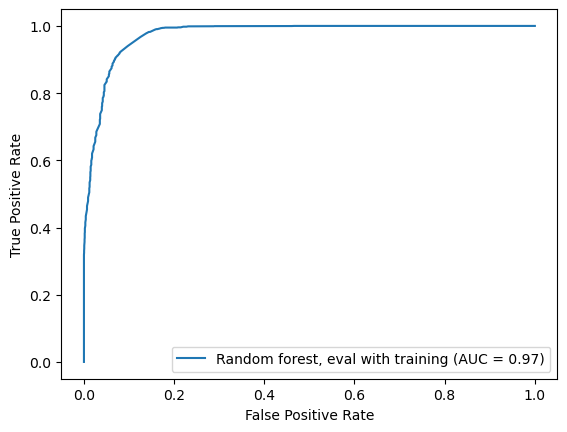

In [7]:
## evaluate this RF model with both train/test data
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay, auc, roc_auc_score

print("Accuracy on training data = {:.4f}".format(rf_model.score(X_train, 
                                                                 y_train)))
print("ROC AUC score on training data = {:.4f}".format(roc_auc_score(y_train, 
                                                                     rf_model.predict_proba(X_train)[:,1])))


print("Accuracy on testing data = {:.4f}".format(rf_model.score(X_test, 
                                                                 y_test)))
print("ROC AUC score on testing data = {:.4f}".format(roc_auc_score(y_test, 
                                                                     rf_model.predict_proba(X_test)[:,1])))

## 
fpr, tpr, thresholds = roc_curve(y_train, rf_model.predict_proba(X_train)[:,1])

roc_auc = auc(fpr, tpr)

display_rf = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='Random forest, eval with training')

display_rf.plot()



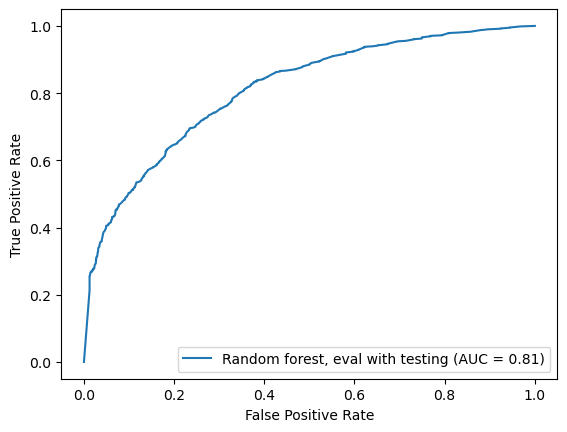

In [8]:
## 
fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1])

roc_auc = auc(fpr, tpr)

display_rf = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='Random forest, eval with testing')

display_rf.plot()

In [9]:
## to evaluate with CV manner
from sklearn.model_selection import cross_val_score, RepeatedKFold

rf_model_cv = RandomForestClassifier()

# define evaluation procedure
rf_cv = RepeatedKFold(n_splits=5 , n_repeats=10, random_state=randomState)

# evaluate model
rf_cv_scores = cross_val_score(rf_model_cv, 
                         X = X_train, 
                         y = y_train,
                         cv= rf_cv, 
                        scoring="roc_auc",
                        n_jobs=-1)
# summarize performance
print('Mean ROC AUC score: %.5f' % np.mean(rf_cv_scores))

## 

Mean ROC AUC score: 0.80413


## 3-2 Hyperparameter tuning

In [10]:
## Find a better set of hyperparameters to avoid overfitting
## the hyperparameters to choose is max_features & min_samples_leaf

max_features = np.arange(1, 4, 1)
min_samples_leaf = np.arange(1, 20, 4)

## number of models = 3 * 5 = 15
## this is grid search
print(max_features)
print(min_samples_leaf)


[1 2 3]
[ 1  5  9 13 17]


In [11]:
## of course you can with 2 loops with RepeatedKFold & cross_val_score functions
## be smart
## https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

from sklearn.model_selection import GridSearchCV

time_start = time.time()

parameters_to_search = {'max_features': max_features, 
              'min_samples_leaf': min_samples_leaf}

rf_model = RandomForestClassifier()

rf_model_CV = GridSearchCV(rf_model, 
                           parameters_to_search, 
                           scoring ="roc_auc", 
                           cv=5, 
                          n_jobs = -1)


rf_model_CV.fit(X_train, y_train)

time_elapsed = time.time() - time_start

In [12]:
## to access the result from CV
rf_model_CV.cv_results_



{'mean_fit_time': array([0.65762706, 0.50071826, 0.44608383, 0.41204662, 0.40744257,
        0.73967929, 0.56998701, 0.51266723, 0.49487004, 0.4735445 ,
        0.85924082, 0.71762462, 0.65754962, 0.59704514, 0.5210372 ]),
 'std_fit_time': array([0.01244022, 0.01012354, 0.00373107, 0.00532923, 0.01400305,
        0.00665207, 0.01830854, 0.00667161, 0.00691396, 0.00516481,
        0.00628045, 0.02266749, 0.00912999, 0.01403733, 0.06275085]),
 'mean_score_time': array([0.05320239, 0.04305372, 0.03431129, 0.03519707, 0.03518071,
        0.04315724, 0.03502235, 0.03483157, 0.03199959, 0.03163452,
        0.04971547, 0.040797  , 0.036584  , 0.03225436, 0.02439208]),
 'std_score_time': array([0.00441813, 0.00609712, 0.00159356, 0.00224141, 0.0039296 ,
        0.00170458, 0.00132382, 0.00059864, 0.00084069, 0.00240019,
        0.00567911, 0.00692829, 0.00226768, 0.00169947, 0.00561306]),
 'param_max_features': masked_array(data=[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
              mask

In [13]:
## the ROC auc score from CV
rf_model_CV.cv_results_["mean_test_score"]

array([0.80255071, 0.82677911, 0.82542401, 0.82442651, 0.82251181,
       0.80224201, 0.82777911, 0.83098861, 0.83032592, 0.83013337,
       0.80032537, 0.82543429, 0.82947652, 0.83157071, 0.83247346])

In [14]:
## to get the best combination

rf_model_CV.best_estimator_
##

RandomForestClassifier(max_features=3, min_samples_leaf=17)

In [15]:
## it may be taking too long to run a grid search 
print("Time elapsed working CV with 3*5=15 conbinations: {:.4f} seconds. With best ROC AUC score {:.4f}".format(
    time_elapsed, rf_model_CV.best_score_))



Time elapsed working CV with 3*5=15 conbinations: 6.5325 seconds. With best ROC AUC score 0.8325


In [ ]:
## what if 3 * 25 * 10?

## don't run this part
## it took me 301 seconds to find "max_depth=12, max_features=3, min_samples_leaf=23"
## with cv score 0.8335


#max_features = np.arange(1, 4, 1)
#min_samples_leaf = np.arange(1, 51, 2)
#max_depth = np.arange(2, 21, 2)
#
#
#time_start = time.time()
#parameters_to_search = {'max_features': max_features, 
#              'min_samples_leaf': min_samples_leaf, 
#                        'max_depth' : max_depth}
#
#rf_model = RandomForestClassifier()
#
#
#rf_model_CV = GridSearchCV(rf_model, 
#                           parameters_to_search, 
#                           scoring ="roc_auc", 
#                           cv=5, 
#                          n_jobs = -1)
#rf_model_CV.fit(X_train, y_train)
#time_elapsed = time.time() - time_start



In [18]:
## random search

from sklearn.model_selection import RandomizedSearchCV

max_features = np.arange(1, 4, 1)
min_samples_leaf = np.arange(1, 51, 2)
max_depth = np.arange(2, 21, 2)

time_start = time.time()
parameters_to_search = {'max_features': max_features, 
              'min_samples_leaf': min_samples_leaf, 
                        'max_depth' : max_depth}

rf_model = RandomForestClassifier()

rf_model_RCV = RandomizedSearchCV(rf_model, 
                           parameters_to_search, 
                           n_iter = 20, #the number of combinations
                           scoring ="roc_auc", 
                           cv=5, 
                          n_jobs = -1)


rf_model_RCV.fit(X_train, y_train)
time_elapsed = time.time() - time_start



In [19]:
print("Time elapsed working CV with 20 random conbinations: {:.4f} seconds. With best ROC AUC score {:.4f}".format(
    time_elapsed, rf_model_RCV.best_score_))



Time elapsed working CV with 20 random conbinations: 6.9630 seconds. With best ROC AUC score 0.8311


In [20]:
rf_model_CV.best_estimator_

##

RandomForestClassifier(max_depth=14, max_features=3, min_samples_leaf=25)

## 3-3 Boosting models
### 3-3-1 GBDT

In [21]:
## GBDT, vanilla
## https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier()

print("With the no-feature-engineering data (missing value only):")
gb_model.fit(X_train, y_train)

print("Accuracy on training data = {:.4f}".format(gb_model.score(X_train, 
                                                                 y_train)))
print("ROC AUC score on training data = {:.4f}".format(roc_auc_score(y_train, 
                                                                     gb_model.predict_proba(X_train)[:,1])))


print("Accuracy on testing data = {:.4f}".format(gb_model.score(X_test, 
                                                                 y_test)))
print("ROC AUC score on testing data = {:.4f}".format(roc_auc_score(y_test, 
                                                                     gb_model.predict_proba(X_test)[:,1])))

With the no-feature-engineering data (missing value only):
Accuracy on training data = 0.7722
ROC AUC score on training data = 0.8528
Accuracy on testing data = 0.7393
ROC AUC score on testing data = 0.8285


In [22]:
## the default number of trees is 100
## however, it might not be optimal
gb_model.n_estimators_


100

In [23]:
## almost the same hyperparameter manner with Random forest

gb_model = GradientBoostingClassifier(
    ## number of trees, NOT the more the better
    n_estimators = 300, 
    
    ## these two controls the size of a tree = prune
    max_depth = 10, 
    min_samples_leaf = 5, 
    
    ## how many features can a decision tree use?
    max_features = "sqrt",
    
    ## by default gbdt dont do bootstrap sampling
    ## subsample less than 1.0 enables sampling
    subsample = 0.7,
    
    ## with enabling subsample, gbdt can also have oob (not score though)
    ## since gbdt "improves" tree by tree
    ## if there is no significant improvement, the whole model can stop before all trees generated
    n_iter_no_change = 10,
    ## leaning rate
    learning_rate = 0.1, 
    
    ## showing messeges
    verbose = 1,
    random_state = randomState
)

print("With the no-feature-engineering data (missing value only):")
gb_model.fit(X_train, y_train)

print("Accuracy on training data = {:.4f}".format(gb_model.score(X_train, 
                                                                 y_train)))
print("ROC AUC score on training data = {:.4f}".format(roc_auc_score(y_train, 
                                                                     gb_model.predict_proba(X_train)[:,1])))


print("Accuracy on testing data = {:.4f}".format(gb_model.score(X_test, 
                                                                 y_test)))
print("ROC AUC score on testing data = {:.4f}".format(roc_auc_score(y_test, 
                                                                     gb_model.predict_proba(X_test)[:,1])))



With the no-feature-engineering data (missing value only):
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3049           0.0607            3.08s
         2           1.2474           0.0513            2.91s
         3           1.1957           0.0421            2.68s
         4           1.1538           0.0367            2.63s
         5           1.1022           0.0281            2.74s
         6           1.0754           0.0248            2.71s
         7           1.0434           0.0184            2.85s
         8           1.0153           0.0144            2.85s
         9           0.9964           0.0118            2.85s
        10           0.9752           0.0135            2.89s
        20           0.8445          -0.0008            2.53s
        30           0.7795          -0.0010            2.32s
        40           0.7471          -0.0017            2.07s
        50           0.7173          -0.0023            1.89s
Accuracy o

In [24]:
## I've previously specified 300 trees for this model
## However, it stop with 52 trees
## Since scikit learn finds that there is no further improvement with more than 52 trees

gb_model.n_estimators_

##

52

### 3-3-2 XGboost

In [25]:
## XGBOOSt is not a scikit-learn model
## the orginal grammar might be slightly different
## https://xgboost.readthedocs.io/en/latest/index.html
## however, there is a sklearn interface for us the adapt the model easily
## https://xgboost.readthedocs.io/en/latest/python/sklearn_estimator.html

import xgboost as xgb

xgb_model = xgb.XGBClassifier(tree_method="hist", 
                              objective='binary:logistic')
xgb_model.fit(X_train, y_train)


print("Accuracy on training data = {:.4f}".format(xgb_model.score(X_train, 
                                                                 y_train)))
print("ROC AUC score on training data = {:.4f}".format(roc_auc_score(y_train, 
                                                                     xgb_model.predict_proba(X_train)[:,1])))


print("Accuracy on testing data = {:.4f}".format(xgb_model.score(X_test, 
                                                                 y_test)))
print("ROC AUC score on testing data = {:.4f}".format(roc_auc_score(y_test, 
                                                                     xgb_model.predict_proba(X_test)[:,1])))


Accuracy on training data = 0.8585
ROC AUC score on training data = 0.9355
Accuracy on testing data = 0.7386
ROC AUC score on testing data = 0.8206


In [26]:
## hyperparameters of XGBOOST
## https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier

xgb_model = xgb.XGBClassifier(
    ## it's a binary classification model
    objective = "binary:logistic", 
    eval_metric = "error", 
    
    ## the way grow a tree
    tree_method = "hist", 
    grow_policy = "depthwise", # default: "depthwise", a more balanced tree. "lossguide" for unbalanced
    
    ## number of trees, NOT the more the better
    n_estimators = 300, 
    
    ## these two controls the size of a tree = prune
    max_depth = 10, # same as GBDT 
    reg_lambda = 1, # the larger the smaller tree
    min_child_weight = 10, # just like "min_samples_leaf"
    
    ## subsample less than 1.0 enables sampling
    subsample = 1,
    
    #early_stopping_rounds = 10, ## n_iter_no_change
    
    ## leaning rate
    learning_rate = 0.1,
    
    ## showing messeges
    verbosity = 1, ## verbose 
    )



xgb_model.fit(X_train, y_train)


print("Accuracy on training data = {:.4f}".format(xgb_model.score(X_train, 
                                                                 y_train)))
print("ROC AUC score on training data = {:.4f}".format(roc_auc_score(y_train, 
                                                                     xgb_model.predict_proba(X_train)[:,1])))


print("Accuracy on testing data = {:.4f}".format(xgb_model.score(X_test, 
                                                                 y_test)))
print("ROC AUC score on testing data = {:.4f}".format(roc_auc_score(y_test, 
                                                                     xgb_model.predict_proba(X_test)[:,1])))



Accuracy on training data = 0.8278
ROC AUC score on training data = 0.9153
Accuracy on testing data = 0.7345
ROC AUC score on testing data = 0.8237


In [ ]:
## the early stopping in GBDT is based on subsample < 1 (oob score)
## however, in the XGBOOST, it's based on test set
## if you want to work in GBDT manner, you have to split the cv set by yourself
## https://xgboost.readthedocs.io/en/latest/python/sklearn_estimator.html#early-stopping

## If you want to work with xgboost more:
## https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn
## https://towardsdatascience.com/20-burning-xgboost-faqs-answered-to-use-the-library-like-a-pro-f8013b8df3e4


### 3-3-3 lightGBM
https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#

In [ ]:
## Target encoding






## 3-4 Learn from models